In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Importing Libraries

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import DataLoader, BatchSampler, Dataset

import os
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import random

#### Setting Seed

In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [3]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any
    randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    return True

<br><br>

# 2. Data preprocessing

#### StormDataset Class

The `StormDataset` class is a custom dataset designed for handling sequences of storm images for prediction from the given dataset. Depending on how the data should be trained/selected in terms of efficiency, the `stride` can be tinkered with. For example, when working with 30 folders, we can reduce the dataset, and reduce overfitting.
## Parameters

- `root`: File directory which contains the storm data image.
- `transform`: Apply image transformations. Default is True.
- `sequence_length`: Length of the image sequences. Default is 5.
- `stride` : Stride for selecting sequences. Is set to 1.
- `folder` : Subfolder containing storm data. set to None.

## Methods

- `__init__(self, root, transform=True, sequence_length=5, stride=1, folder=None)`: Initializes the dataset with the specified parameters.
- `_get_all_storm_sequences(self)`: Retrieves all sequences of storm images from the dataset.
- `_get_storm_sequences(self, storm_path)`: Splits storms into sequences based on the specified path.
- `_get_image_paths(self, storm_path, exts=(".jpg"))`: Gets the paths of storm images with a specified extension (sub-directories within the folder).
- `__getitem__(self, idx)`: Returns a sequence of images and thee target image at the specified index.
- `__len__(self)`: Returns the total number of sequences in the dataset.
- `__str__(self)`: Returns a string representation of the class, displaying the class name, length, and other relevant attributes.


In [4]:
class StormDataset(Dataset):
    """
    Custom dataset for handling sequences of storm images for prediction.

    Args:
        root (str): Root directory containing storm image data.
        transform (bool, optional): Apply image transformations. Default is True.
        sequence_length (int, optional): Length of the image sequences. Default is 5.
        folder (str, optional): Subfolder containing storm data. Default is None.
    """

    def __init__(self, root, transform=True, sequence_length=5, stride=1, folder=None):
        self.transform = transform
        self.root = root
        self.sequence_length = sequence_length
        self.folder = folder
        self.stride = stride
        self.data = self._get_all_storm_sequences()

    def _get_all_storm_sequences(self):
        all_sequences = []
        if self.folder:
        # just consider one specfic folder
            storm_path = os.path.join(self.root, self.folder)
            storm_sequences = self._get_storm_sequences(storm_path)
            for seq in storm_sequences:
                all_sequences.append(seq)
        else:
        # go through all folders
            for storm_folder in os.listdir(self.root):
                storm_path = os.path.join(self.root, storm_folder)
                if os.path.isdir(storm_path):
                    storm_sequences = self._get_storm_sequences(storm_path)
                    for seq in storm_sequences:
                        all_sequences.append(seq)
        return all_sequences


    def _get_storm_sequences(self, storm_path):
        '''split storms into sequence'''
        paths = self._get_image_paths(storm_path)
        sequences = []
        for i in range(0, len(paths) - self.sequence_length, self.stride):
            sequence = paths[i:i + self.sequence_length]
            sequences.append(sequence)
        return sequences

    def _get_image_paths(self, storm_path, exts=(".jpg")):
        data = []
        for root, dirs, files in os.walk(storm_path):
            for file in files:
                if file.endswith(exts):
                    img_path = os.path.join(root, file)
                    num_path = img_path.removesuffix('.jpg')
                    try:
                        features_path = num_path + "_features.json"
                        if os.path.exists(features_path):
                            with open(features_path, 'r') as f:
                                features = json.load(f)
                                time_feature = features.get('relative_time')
                                if time_feature is not None:
                                    data.append((img_path, int(time_feature)))
                    except UnidentifiedImageError:
                        print('image error')
                        pass

        data.sort(key=lambda x: x[1])
        return [item[0] for item in data]

    def __getitem__(self, idx):
        sequence_paths = self.data[idx]
        images = []
        for img_path in sequence_paths[:-1]:
            img = Image.open(img_path).convert('L')
            if self.transform:
                transform = transforms.Compose([
                    transforms.Resize((336, 336)),
                    transforms.ToTensor()
                ])
                img = transform(img)
            images.append(img)

        target_img_path = sequence_paths[-1]
        target_img = Image.open(target_img_path).convert('L')
        if self.transform:
            target_img = transform(target_img)

        return torch.stack(images), target_img

    def __len__(self):
        return len(self.data)

    def __str__(self):
        class_string = self.__class__.__name__
        class_string += f"\n\tlen : {self.__len__()}"
        for key, value in self.__dict__.items():
            class_string += f"\n\t{key} : {value}"
        return class_string

total 30:

#### Enter File Path Below:

In [ ]:
dataset_root = "/content/gdrive/MyDrive/Selected_Storms_curated"
dataset = StormDataset(root=dataset_root, transform=True, sequence_length=6, stride=1)

NameError: name 'StormDataset' is not defined

suprise:

In [5]:
surprise_dataset_root = "/content/gdrive/MyDrive/Surprise_Storm"
surprise_dataset = StormDataset(root=surprise_dataset_root, transform=True, sequence_length=6, stride=1)

####Visual representation of the data.

Sample 0:
- Sequence Length: 9
- Shape of Each Image in Sequence: torch.Size([1, 128, 128])
- Shape of Target Image: torch.Size([1, 128, 128])


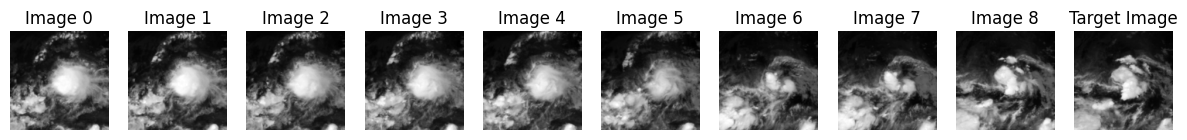

Sample 1:
- Sequence Length: 9
- Shape of Each Image in Sequence: torch.Size([1, 128, 128])
- Shape of Target Image: torch.Size([1, 128, 128])


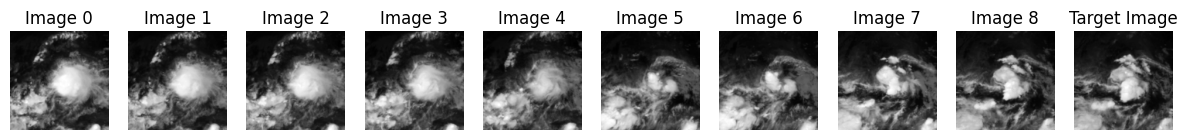

Sample 2:
- Sequence Length: 9
- Shape of Each Image in Sequence: torch.Size([1, 128, 128])
- Shape of Target Image: torch.Size([1, 128, 128])


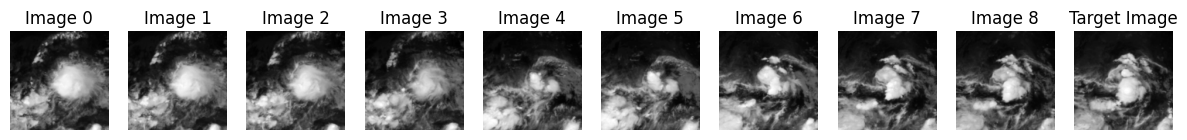

In [ ]:
# Check the first few items in the dataset
num_items_to_check = 3
for i in range(num_items_to_check):
    images, target_image = dataset[i]
    print(f"Sample {i}:")
    print(f"- Sequence Length: {len(images)}")
    print(f"- Shape of Each Image in Sequence: {images[0].shape}")
    print(f"- Shape of Target Image: {target_image.shape}")

    # Optionally display the images
    fig, axs = plt.subplots(1, len(images) + 1, figsize=(15, 5))
    for j, img in enumerate(images):
        axs[j].imshow(img.squeeze(), cmap='gray')
        axs[j].set_title(f"Image {j}")
        axs[j].axis('off')

    axs[-1].imshow(target_image.squeeze(), cmap='gray')
    axs[-1].set_title("Target Image")
    axs[-1].axis('off')

    plt.show()


<br><br><br>

# 3. Network design and implementation


## Convolutional LSTM-based Sequence-to-Sequence Modeling

### Overview
We utilised encoders and decoders becuase they combine input features, and features from previous time steps.
This code defines a sequence-to-sequence (seq2seq) autoencoder architecture using Convolutional LSTM cells. This architecture consists of three main components, which are: ConvLSTMCell, ConvEncoder, and ConvDecoder. These  are used to construct a Seq2SeqAutoencoder model.



### Components
- `ConvLSTMCell`: This custom implementation of a Convolutional LSTM cell, which uses Conv2d layers and ELU activation functions.

- `ConvEncoder`: The encoder uses ConvLSTMCell for encoding the input sequences and applies batch normalisation and dropout for regularisation.

- `ConvDecoder`: Applies a ConvLSTMCell for decoding, uses batch normalisation.
 We tried to use an `attention` mechanism, but it did not make any significant improvements, and it took too long.

- `Seq2SeqAutoencoder`: Combines the aforementioned `ConvEncoder` and `ConvDecoder` to form the complete autoencoder model.

### Model Initialisation and Testing
The model is initialised with the following hyperparameters: input_channels, hidden_channels, output_channels, kernel_size, and sequence_length. A test input tensor is generated, and the model is run to verify the output shape.
We changed and fine tuned the hidden channels from 256 to 128 becuase it took too long to run. we also tried 64, but it was not capturing all the points.
We also used a kernel size of 3, but the generated images were not clear, they were very ambiguous.

```python
# Model initialization
input_channels = 1
hidden_channels = 128
output_channels = 1
kernel_size = 1
sequence_length = 5

model = Seq2SeqAutoencoder(input_channels, hidden_channels, output_channels, kernel_size)

# Test the model
input_tensor = torch.rand(1, sequence_length, input_channels, 224, 224)
output = model(input_tensor)
print(output.shape)  # Check the output shape

```

This model was influenced by the the model in `PSIque: Next Sequence Prediction of Satellite Images using a Convolutional Sequence-to-Sequence Network` paper. We simplified and fine tuned it to find the best parameters for our dataset and task.

In [6]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(in_channels=self.input_channels + self.hidden_channels,
                              out_channels=4 * self.hidden_channels,
                              kernel_size=self.kernel_size,
                              padding=self.padding)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        combined_conv = F.elu(combined_conv)  # Applying ELU activation

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        device = next(self.parameters()).device
        return (torch.zeros(batch_size, self.hidden_channels, height, width, device=device),
                torch.zeros(batch_size, self.hidden_channels, height, width, device=device))

class ConvEncoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, dropout_prob=0.7):
        super(ConvEncoder, self).__init__()
        self.conv_lstm1 = ConvLSTMCell(input_channels, hidden_channels // 2, kernel_size)

        self.batch_norm = nn.BatchNorm2d(hidden_channels // 2)
        self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, input_tensor):
        batch_size, seq_len, _, height, width = input_tensor.size()
        h, c = self.conv_lstm1.init_hidden(batch_size, (height, width))
        last_state = None

        for t in range(seq_len):
            h, c = self.conv_lstm1(input_tensor[:, t, :, :, :], (h, c))

            h = self.batch_norm(h)
            h = self.dropout(h)
            if t == seq_len - 1:
                last_state = h

        return last_state, (h, c)

class ConvDecoder(nn.Module):
    def __init__(self, hidden_channels, output_channels, kernel_size, dropout_prob=0.7):
        super(ConvDecoder, self).__init__()
        self.conv_lstm1 = ConvLSTMCell(hidden_channels // 2, hidden_channels // 2, kernel_size)
        self.batch_norm = nn.BatchNorm2d(hidden_channels // 2)
        self.conv = nn.Conv2d(hidden_channels // 2, output_channels, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, encoder_last_state, h, c, seq_len):
        outputs = []

        for t in range(seq_len):
            h, c = self.conv_lstm1(h, (h, c))
            h = self.batch_norm(h)
            if t == 0:
                h = h + encoder_last_state
            h = self.dropout(h)
            outputs.append(h)

        output = self.conv(outputs[-1])
        output = output.unsqueeze(1)

        return output

class Seq2SeqAutoencoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, kernel_size):
        super(Seq2SeqAutoencoder, self).__init__()
        self.encoder = ConvEncoder(input_channels, hidden_channels, kernel_size)
        self.decoder = ConvDecoder(hidden_channels, output_channels, kernel_size)

    def forward(self, input_tensor):
        encoder_last_state, (h, c) = self.encoder(input_tensor)
        output = self.decoder(encoder_last_state, h, c, seq_len=1)
        return output

# Model initialization
input_channels = 1
hidden_channels = 128
output_channels = 1
kernel_size = 1
sequence_length = 5

model = Seq2SeqAutoencoder(input_channels, hidden_channels, output_channels, kernel_size)

# Test the model
input_tensor = torch.rand(1, sequence_length, input_channels, 224, 224)
output = model(input_tensor)
print(output.shape)  # Check the output shape

torch.Size([1, 1, 1, 224, 224])


####Task 1 Train test split. It can be ignored when testing the surprise storm.

In [ ]:
# Determine split sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - (train_size + val_size)

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

NameError: name 'dataset' is not defined

### DataLoaders and TrainTestSplit

In [7]:
# Determine split sizes
total_size = len(surprise_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - (train_size + val_size)

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    surprise_dataset, [train_size, val_size, test_size])

In [8]:
# Define batch size
batch_size = 5

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



<br>
<br>
<br>
<br>

## SSIM-Based Loss for Training and Evaluation

This code defines functions for training and evaluating our model using the Structural Similarity Index (SSIM) as a loss metric. SSIM measures the similarity between two images. It focuses on the luminance, contrast, and structure.

### Functions:
- `train(model, dataloader, optimizer, device)`: Performs model training using SSIM loss. It computes SSIM loss for each batch (as defined above), and updates the model parameters.

- `evaluate(model, dataloader, device)`: Evaluates the model using SSIM loss on our dataloader and calculates the average SSIM loss over all the batches.

### Parameters:
- `model`: seq2seq model to be trained or evaluated.
- `dataloader`: train_loader DataLoader which contain input-target pairs for training and evaluation.
- `optimiser`: PyTorch optimizer used for updating model parameters during training.
- `device`: GPU/CUDA which is where my model and data are placed.

### Note:
- SSIM loss is calculated by subtracting the SSIM score from 1. The lower the loss, the higher the similarity between predicted and target images.



In [9]:
# ! pip install pytorch_msssim

In [10]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # Remove the sequence length dimension while keeping the channel dimension
        outputs = outputs.squeeze(2)

        # Calculate SSIM loss
        loss = 1 - ssim(outputs, targets, data_range=255, size_average=True)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = outputs.squeeze(2)

            # Calculate SSIM score
            ssim_score = ssim(outputs, targets, data_range=255, size_average=True)
            loss = 1 - ssim_score

            total_loss += loss.item()


    average_loss = total_loss / len(dataloader)
    return average_loss




In [11]:
model.to(device)

Seq2SeqAutoencoder(
  (encoder): ConvEncoder(
    (conv_lstm1): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout2d(p=0.7, inplace=False)
  )
  (decoder): ConvDecoder(
    (conv_lstm1): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (dropout): Dropout2d(p=0.7, inplace=False)
  )
)

## Loss-plot Function, Saving, Training & Validation of model.

In [30]:
# Plot the loss
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [28]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, device)
    val_loss = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation loss: {val_loss}")


Epoch 1, Train Loss: 0.003927804742540632, Validation loss: 0.0015002265572547913
Epoch 2, Train Loss: 0.0033700227737426757, Validation loss: 0.0016181319952011108
Epoch 3, Train Loss: 0.003356976168496268, Validation loss: 0.001785382628440857
Epoch 4, Train Loss: 0.0032253520829336984, Validation loss: 0.0015669390559196472
Epoch 5, Train Loss: 0.002896531990596226, Validation loss: 0.0014149472117424011
Epoch 6, Train Loss: 0.003198564052581787, Validation loss: 0.0014801844954490662
Epoch 7, Train Loss: 0.0031451821327209474, Validation loss: 0.0014801695942878723
Epoch 8, Train Loss: 0.0030761565480913436, Validation loss: 0.001516297459602356
Epoch 9, Train Loss: 0.0030118141855512348, Validation loss: 0.00141085684299469
Epoch 10, Train Loss: 0.0027791619300842284, Validation loss: 0.001429915428161621
Epoch 11, Train Loss: 0.002829582350594657, Validation loss: 0.0014472976326942444
Epoch 12, Train Loss: 0.0029853480202811106, Validation loss: 0.0013818517327308655
Epoch 13, T

In [29]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/task1_model.pth')

In [ ]:
model = Seq2SeqAutoencoder(input_channels, hidden_channels, output_channels, kernel_size)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/task1_model.pth'))

<All keys matched successfully>

<br><br>

# 4. Prediction

# Storm Dataset Prediction Pipeline

## Overview
This code defines a "pipeline" to make predictions on the last four images. It utilises our `StormDataset` class, loads the last four images, and makes predictions based on the model.

## Functions
1. `get_last_tensors()`: Fetches the last four images, preprocesses them, and returns three tensors: `last_tensors`, `last_three`, and `last_two`.
2. `make_prediction(model, device, last_tensors)`: Makes predictions using our model on the input tensors.
3. `save_tensor(tensor, i)`: Saves the tensors as an image and displays the image.

## Pipeline
1. Fetch the last four images using `get_last_tensors()`.
2. Make the first prediction (`prediction_1`) based on the last four images.
3. Concatenate the last three images and `prediction_1` for the second prediction (`prediction_2`).
4. Concatenate the last two images, `prediction_1`, and `prediction_2` for the final prediction (`prediction_3`).
5. Save and display the predicted images using `save_tensor()`.



In [13]:
def get_last_tensors():
  image_directory = "/content/gdrive/MyDrive/Surprise_Storm/tst"

  # Get all .jpg files in the directory
  image_files = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith('.jpg')]

  image_files.sort()

  # Get the last four images
  last_four_images = image_files[-4:]

  print("Last four images:", last_four_images)

  images = []
  for img_path in last_four_images:
    img = Image.open(img_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((336, 336)),
        transforms.ToTensor()
        ])
    img = transform(img)
    images.append(img)

  last_tensors = torch.stack(images).unsqueeze(0)
  last_three = torch.stack(images[-3:]).unsqueeze(0)
  last_two = torch.stack(images[-2:]).unsqueeze(0)

  return last_tensors, last_three, last_two


In [14]:
last_tensors, last_three, last_two  = get_last_tensors()

Last four images: ['/content/gdrive/MyDrive/Surprise_Storm/tst/tst_248.jpg', '/content/gdrive/MyDrive/Surprise_Storm/tst/tst_249.jpg', '/content/gdrive/MyDrive/Surprise_Storm/tst/tst_250.jpg', '/content/gdrive/MyDrive/Surprise_Storm/tst/tst_251.jpg']


In [15]:
def make_prediction(model, device, last_tensors):
  model.eval()
  model.to(device)

  with torch.no_grad():
      last_tensors = last_tensors.to(device)
      prediction = model(last_tensors)

  return prediction


In [16]:
prediction_1 = make_prediction(model, device, last_tensors)

last_three = last_three.to(device)
# Concatenate along the second dimension (dimension index 1)
last_tensors_2 = torch.cat((last_three, prediction_1), dim=1)

prediction_2 = make_prediction(model, device, last_tensors_2)

last_two = last_two.to(device)

# Concatenate along the second dimension (dimension index 1)
last_tensors_3 = torch.cat((last_two, prediction_1, prediction_2), dim=1)

prediction_3 = make_prediction(model, device, last_tensors_3)


In [17]:
def save_tensor(tensor, i):
    tensor = tensor.squeeze()
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

    # Ensure tensor is of type float32 for saving
    tensor = tensor.type(torch.FloatTensor)

    # Save the tensor as an image
    save_image(tensor, f'/content/gdrive/MyDrive/test_predict_{i}.jpg')

    # Plotting the image
    plt.imshow(tensor.cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

# Displaying the three generated images (the predictions).

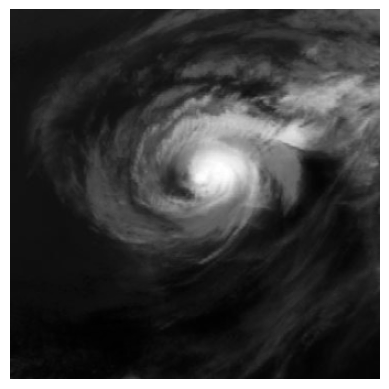

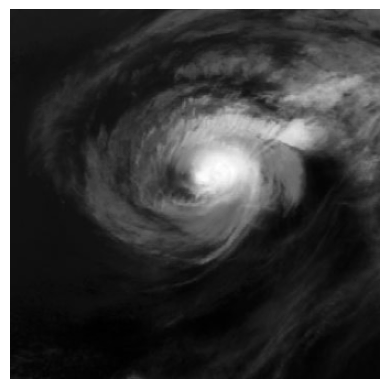

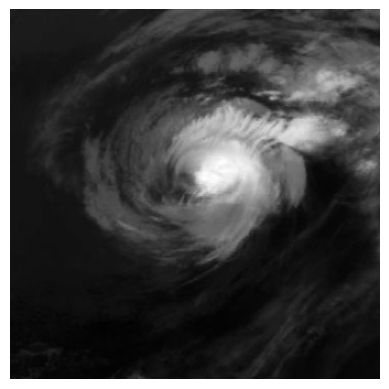

In [18]:
save_tensor(prediction_1, 1)
save_tensor(prediction_2, 2)
save_tensor(prediction_3, 3)

# Evaluation

In [ ]:
def psnr(predicted, target):
    mse = torch.mean((predicted - target) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 1.0
    return 20 * torch.log10(PIXEL_MAX / torch.sqrt(mse))

def mse(predicted, target):
    return torch.mean((predicted - target) ** 2)

In [ ]:
model.eval()

Seq2SeqAutoencoder(
  (encoder): ConvEncoder(
    (conv_lstm1): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout2d(p=0.7, inplace=False)
  )
  (decoder): ConvDecoder(
    (conv_lstm1): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (dropout): Dropout2d(p=0.7, inplace=False)
  )
)

In [ ]:
model.to(device)

Seq2SeqAutoencoder(
  (encoder): ConvEncoder(
    (conv_lstm1): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout2d(p=0.7, inplace=False)
  )
  (decoder): ConvDecoder(
    (conv_lstm1): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (dropout): Dropout2d(p=0.7, inplace=False)
  )
)

In [ ]:
predictions = []
ground_truths = []

with torch.no_grad():  # No need to track gradients
    for inputs, real_images in test_loader:
        inputs = inputs.to(device)
        predicted_images = model(inputs)

        predicted_image = predicted_images.squeeze().cpu()

        # Store predictions and targets for evaluation
        predictions.append(predicted_images.squeeze().cpu())
        ground_truths.append(real_images.squeeze().cpu())
